# Bangkit Capstone Project 2022
##  C22-PS154



### Overview
* **Download and extract Food 101 dataset**
* **Understand dataset structure and files** 
* **Visualize random image from each of the 101 classes**
* **Split the image data into train and test using train.txt and test.txt**
* **Create a subset of data with few classes(3) - train_mini and test_mini for experimenting**
* **Fine tune Inception Pretrained model using Food 101 dataset**
* **Visualize accuracy and loss plots**
* **Predicting classes for new images from internet**
* **Scale up and fine tune Inceptionv3 model with 11 classes of data**
* **Summary of the things I tried**
* **Further improvements**
* **Feedback**

Kukus V4: detect 16 class of food

### Load Required Modules

In [ ]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
import numpy as np
import os
from zipfile import ZipFile
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.image as img
from collections import defaultdict
import collections

In [ ]:
# Check if GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.8.2
/device:GPU:0


In [ ]:
# mount the ipynb to google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.listdir()

['.config', 'drive', 'sample_data']

In [ ]:
from zipfile import ZipFile

with ZipFile('drive/MyDrive/Capstone Bangkit Dataset/dataset food101_v5.zip', 'r') as zip_obj:
  zip_obj.extractall("food-101")

### Understand dataset structure and files 

**The dataset being used is [Food 101](https://www.vision.ee.ethz.ch/datasets_extra/food-101/)**
* **This dataset has 101000 images in total. It's a food dataset with 101 categories(multiclass)**
* **Each type of food has 750 training samples and 250 test samples**
* **Note found on the webpage of the dataset :  **  
***On purpose, the training images were not cleaned, and thus still contain some amount of noise. This comes mostly in the form of intense colors and sometimes wrong labels. All images were rescaled to have a maximum side length of 512 pixels.***  
* **The entire dataset is 5GB in size**

In [ ]:
# Check the extracted dataset folder
!ls food-101/

test_mini  train_mini


### Visualize random image from each of the 15 classes

google drive -> tinggal ganti variable data_dir untuk liat(visualisasiin) datanya

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
import os

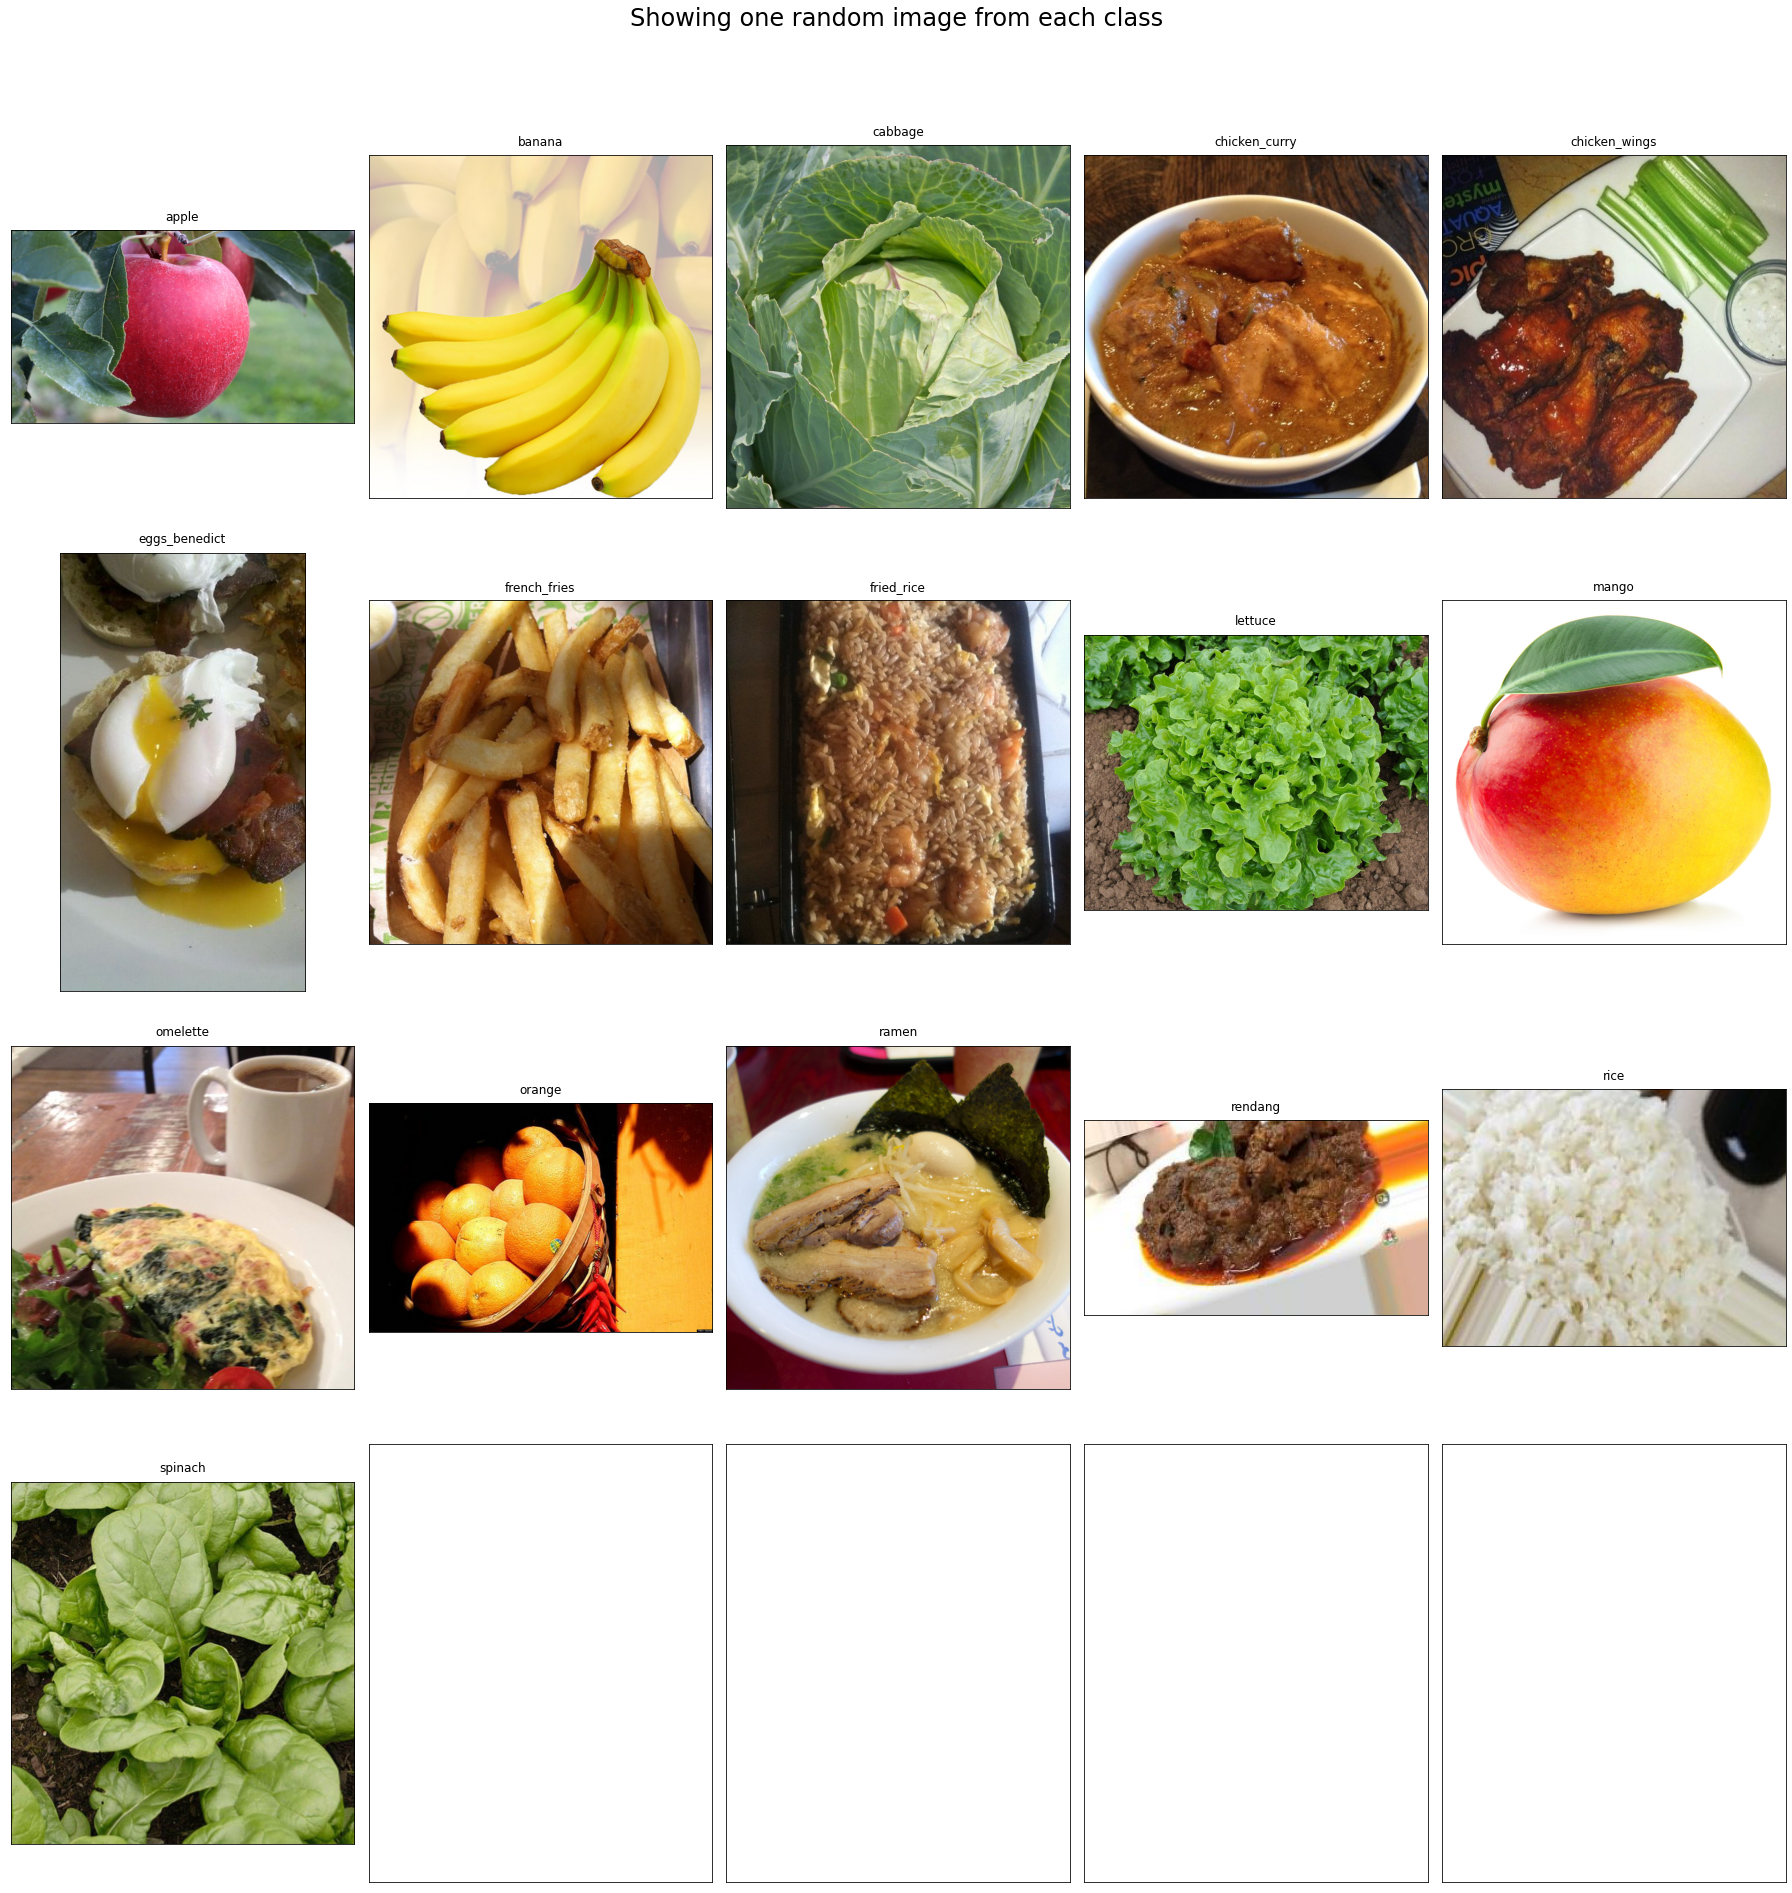

In [ ]:
# Visualize the data, showing one image per class from 15 classes
rows = 4
cols = 5
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/train_mini/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
  for j in range(cols):
    try:
      food_selected = foods_sorted[food_id] 
      food_id += 1
    except:
      break
    food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
    food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
    img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
    ax[i][j].imshow(img)
    ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


In [ ]:
# untuk lihat jumlah data yang ada di custom dataset, tinggal ganti file directorynya

# Check how many files are in the train folder
train_samples = 0
num_classes = 0
dir_path = 'food-101/train_mini/'
#Diganti jadi gini biar ga hardcode buat jumlah sample yang dipake di section abis ini
for base, dirs, files in os.walk(dir_path):
    for dir in dirs:
        num_classes += 1
    for file in files:
        train_samples += 1
print("Number of classes in datasets:", num_classes)
print("Total number of samples in train folder:", train_samples)

Number of classes in datasets: 16
Total number of samples in train folder: 5885


In [ ]:
# untuk lihat jumlah data yang ada di custom dataset, tinggal ganti file directorynya

# Check how many files are in the test folder
test_samples = 0
dir_path = 'food-101/test_mini/'
for base, dirs, files in os.walk(dir_path):
    for file in files:
        test_samples += 1
print("Total number of samples in test folder:", test_samples)

Total number of samples in test folder: 1826


In [ ]:
# daftar makanan yang mau diprediksi
food_list = ['apple',
             'banana',
             'cabbage',
             'chicken_curry',
             'chicken_wings',
             'eggs_benedict',
             'french_fries',
             'fried_rice',
             'lettuce',
             'mango',
             'omelette',
             'orange',
             'ramen',
             'rendang',
             'rice',
             'spinach']

### Fine tune Inception Pretrained model using Food 101 dataset

* Keras and other Deep Learning libraries provide pretrained models  
* These are deep neural networks with efficient architectures(like VGG,Inception,ResNet) that are already trained on datasets like ImageNet  
* Using these pretrained models, we can use the already learned weights and add few layers on top to finetune the model to our new data  
* This helps in faster convergance and saves time and computation when compared to models trained from scratch

* We currently have a subset of dataset with 3 classes - samosa, pizza and omelette  
* Use the below code to finetune Inceptionv3 pretrained model

In [ ]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
import numpy as np



K.clear_session()

# jumlah kelas berdasarkan banyaknya data yang ingin dideteksi
# n_classes = 16

img_width, img_height = 299, 299
train_data_dir = 'food-101/train_mini'
validation_data_dir = 'food-101/test_mini'

# data ini didapat dari jumlah banyaknya data test dan train
#nb_train_samples = 5867 #75750
#nb_validation_samples = 1841 #25250


batch_size = 16

#Augmentationnya diapus soalnya nurunin train accnya
train_datagen = ImageDataGenerator(rescale=1. / 255)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
for layer in inception.layers:
  layer.trainable = False

#Model ini yang ngehasil acc 84% sm val acc 85% tanpa trainable dari inceptionnya
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
#x = Dense(64, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(num_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')

model.summary()


Found 5885 images belonging to 16 classes.
Found 1826 images belonging to 16 classes.
87924736/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d (Conv2D)                (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, No

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


 ormalization)                  96)                                                               
                                                                                                  
 activation_13 (Activation)     (None, None, None,   0           ['batch_normalization_13[0][0]'] 
                                48)                                                               
                                                                                                  
 activation_16 (Activation)     (None, None, None,   0           ['batch_normalization_16[0][0]'] 
                                96)                                                               
                                                                                                  
 average_pooling2d_1 (AveragePo  (None, None, None,   0          ['mixed0[0][0]']                 
 oling2D)                       256)                                                              
          

In [ ]:
history = model.fit(train_generator,
                    steps_per_epoch = train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=test_samples // batch_size,
                    epochs=25,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained_15class.hdf5')

Epoch 1/25
 72/367 [====>.........................] - ETA: 43s - loss: 2.8234 - accuracy: 0.1684

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


171/367 [============>.................] - ETA: 29s - loss: 2.4672 - accuracy: 0.3121

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


367/367 [==============================] - ETA: 0s - loss: 2.1323 - accuracy: 0.4502
Epoch 1: val_loss improved from inf to 1.44290, saving model to best_model_3class.hdf5
367/367 [==============================] - 86s 195ms/step - loss: 2.1323 - accuracy: 0.4502 - val_loss: 1.4429 - val_accuracy: 0.7379
Epoch 2/25
367/367 [==============================] - ETA: 0s - loss: 1.4726 - accuracy: 0.6543
Epoch 2: val_loss improved from 1.44290 to 1.10432, saving model to best_model_3class.hdf5
367/367 [==============================] - 68s 186ms/step - loss: 1.4726 - accuracy: 0.6543 - val_loss: 1.1043 - val_accuracy: 0.7812
Epoch 3/25
367/367 [==============================] - ETA: 0s - loss: 1.2086 - accuracy: 0.7166
Epoch 3: val_loss improved from 1.10432 to 0.93930, saving model to best_model_3class.hdf5
367/367 [==============================] - 68s 186ms/step - loss: 1.2086 - accuracy: 0.7166 - val_loss: 0.9393 - val_accuracy: 0.8125
Epoch 4/25
367/367 [==============================] 

### Visualize the accuracy and loss plots

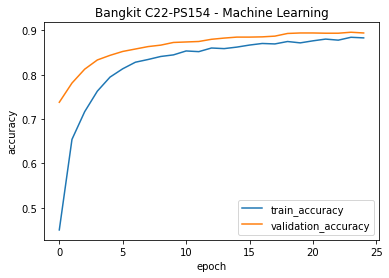

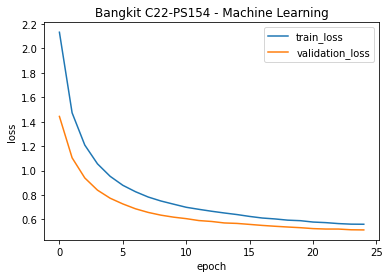

In [ ]:
import matplotlib.pyplot as plt
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'Bangkit C22-PS154 - Machine Learning')
plot_loss(history,'Bangkit C22-PS154 - Machine Learning')

* **The plots show that the accuracy of the model increased with epochs and the loss has decreased**
* **Validation accuracy has been on the higher side than training accuracy for many epochs**
* **This could be for several reasons:**
  * We used a pretrained model trained on ImageNet which contains data from a variety of classes
  * Using dropout can lead to a higher validation accuracy
* **The best model saved has a Top-1 validation accuracy of 93%**
 


### Predicting classes for new images from internet using the best trained model

In [ ]:
# Loading the best saved model to make predictions
%%time
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

K.clear_session()
model_best = load_model('best_model_3class.hdf5',compile = False)

CPU times: user 2.11 s, sys: 172 ms, total: 2.29 s
Wall time: 2.26 s


* **Setting compile=False and clearing the session leads to faster loading of the saved model**
* **Withouth the above addiitons, model loading was taking more than a minute!**

In [ ]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def predict_class(model, images, show = True):
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    print(f'prediction: {pred}')

    index = np.argmax(pred)
    print(f'index: {index}')

    food_list.sort()
    print(f'Food list: {food_list}')

    pred_value = food_list[index]
    print(f"gambar prediksi: {pred_value}")

    print("===========")
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

In [ ]:
# Downloading images from internet using the URLs
!wget -O chicken_curry.jpg https://img-global.cpcdn.com/recipes/fec707d2c73e9285/1200x630cq70/photo.jpg
!wget -O chicken_wings.jpg https://img-global.cpcdn.com/recipes/c1accec228374faa/1200x630cq70/photo.jpg
!wget -O omelette.jpg https://img-global.cpcdn.com/recipes/52a433e2e240e5b0/1200x630cq70/photo.jpg
!wget -O telor_ceplok.jpg https://asset-a.grid.id/crop/0x0:0x0/700x0/photo/2019/07/23/1457258791.jpg 
!wget -O nasi_goreng.jpg https://cdn-2.tstatic.net/travel/foto/bank/images/kuliner-nasi-goreng-jawa-enak-untuk-menu-sarapan.jpg
!wget -O kentang_goreng.jpg https://img-global.cpcdn.com/recipes/67a131223d366f38/1200x630cq70/photo.jpg
!wget -O mie.jpg https://img-global.cpcdn.com/recipes/b456dd2a28e56331/680x482cq70/mie-kuah-cengek-pedas-manis-foto-resep-utama.jpg
!wget -O selada.jpg https://asset-a.grid.id/crop/0x0:0x0/x/photo/2020/01/18/70344440.jpg 
!wget -O rendang.jpg https://images.solopos.com/2020/07/rendang-.jpg 


# If you have an image in your local computer and want to try it, uncomment the below code to upload the image files

# from google.colab import files
# image = files.upload()

--2022-06-11 13:52:50--  https://img-global.cpcdn.com/recipes/fec707d2c73e9285/1200x630cq70/photo.jpg
Resolving img-global.cpcdn.com (img-global.cpcdn.com)... 151.101.2.132, 151.101.66.132, 151.101.130.132, ...
Connecting to img-global.cpcdn.com (img-global.cpcdn.com)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67072 (66K) [image/jpeg]
Saving to: ‘chicken_curry.jpg’

chicken_curry.jpg   100%[===================>]  65.50K  --.-KB/s    in 0.01s   

2022-06-11 13:52:50 (5.39 MB/s) - ‘chicken_curry.jpg’ saved [67072/67072]

--2022-06-11 13:52:50--  https://img-global.cpcdn.com/recipes/c1accec228374faa/1200x630cq70/photo.jpg
Resolving img-global.cpcdn.com (img-global.cpcdn.com)... 151.101.2.132, 151.101.66.132, 151.101.130.132, ...
Connecting to img-global.cpcdn.com (img-global.cpcdn.com)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 97089 (95K) [image/jpeg]
Saving to: ‘chicken_wings.jpg’

chicken_wings.jp

In [ ]:
!wget -O rendang_aja.jpg https://cdns.klimg.com/kapanlagi.com/p/headline/476x238/6-cara-membuat-rendang-praktis-dan-enak-9f70e9.jpg 
!wget -O nasi.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS8DkPQ_tNFjWVbFpFppHQ57KaeOnm2G4VWyQ&usqp=CAU
!wget -O rendang3.jpg https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQeGXJFVPL7R_WUXlvlQ8r5FiUcN8xB0sk_CQ&usqp=CAU 
!wget -O rendang4.jpg https://t-2.tstatic.net/tribunnewswiki/foto/bank/images/ilustrasi-rendang.jpg

--2022-06-11 13:53:00--  https://cdns.klimg.com/kapanlagi.com/p/headline/476x238/6-cara-membuat-rendang-praktis-dan-enak-9f70e9.jpg
Resolving cdns.klimg.com (cdns.klimg.com)... 23.220.206.20, 23.220.206.41
Connecting to cdns.klimg.com (cdns.klimg.com)|23.220.206.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38972 (38K) [image/jpeg]
Saving to: ‘rendang_aja.jpg’

rendang_aja.jpg     100%[===================>]  38.06K  --.-KB/s    in 0.002s  

2022-06-11 13:53:00 (15.9 MB/s) - ‘rendang_aja.jpg’ saved [38972/38972]

--2022-06-11 13:53:00--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcS8DkPQ_tNFjWVbFpFppHQ57KaeOnm2G4VWyQ
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 64.233.191.113, 64.233.191.138, 64.233.191.102, ...
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|64.233.191.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7305 (7.1K) [image/jpeg]
Saving to: ‘nasi.jpg’

nasi.jp

['chicken_curry.jpg', 'chicken_wings.jpg', 'omelette.jpg', 'nasi_goreng.jpg', 'kentang_goreng.jpg', 'mie.jpg', 'telor_ceplok.jpg', 'rendang.jpg', 'rendang_aja.jpg', 'rendang4.jpg', 'nasi.jpg']
prediction: [[4.6415915e-04 1.2159549e-04 1.0633598e-04 8.8506573e-01 7.4761830e-02
  7.6813682e-04 2.9588931e-03 1.7627905e-03 5.7558581e-04 6.2132988e-04
  2.4693437e-02 6.6586398e-04 2.1777702e-03 4.2664111e-03 1.6722140e-04
  8.2282332e-04]]
index: 3
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: chicken_curry


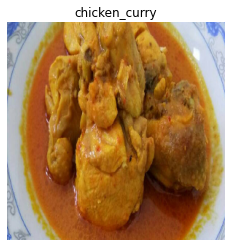

prediction: [[1.2233344e-04 1.3803055e-04 8.0129743e-05 1.2388413e-02 9.3453002e-01
  2.0042057e-03 1.5317990e-03 1.6080259e-04 3.4191654e-04 4.3264966e-04
  4.7374655e-02 9.3491239e-05 1.7714610e-05 3.3927432e-04 1.1132268e-04
  3.3326412e-04]]
index: 4
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: chicken_wings


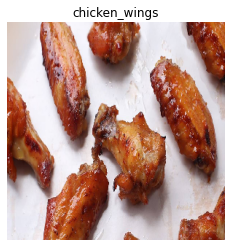

prediction: [[2.8407751e-04 2.4560018e-04 3.2127171e-04 1.1606627e-02 3.0321388e-03
  4.1752271e-03 3.4975486e-03 1.4670361e-03 1.2157778e-04 2.9307805e-04
  9.7042644e-01 1.2339110e-04 2.8310807e-03 7.7048840e-04 4.5085332e-04
  3.5345674e-04]]
index: 10
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: omelette


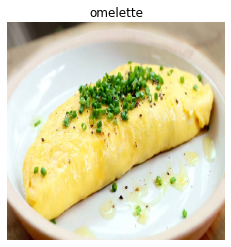

prediction: [[0.00156636 0.00095945 0.00138432 0.15237592 0.23398955 0.00531884
  0.01530146 0.4787923  0.00167866 0.00180984 0.09120494 0.00121009
  0.00131439 0.00548478 0.0041112  0.00349789]]
index: 7
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: fried_rice


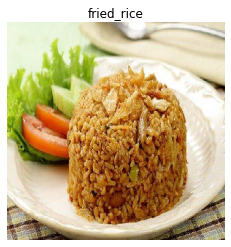

prediction: [[3.6462581e-07 3.6132275e-07 2.7249087e-07 4.4258456e-07 8.1776778e-07
  2.1043856e-07 9.9999523e-01 3.4277555e-08 6.2222604e-08 4.7945343e-07
  8.9327068e-07 1.8699433e-07 2.8618797e-07 1.2089599e-07 7.7372029e-08
  1.2843968e-07]]
index: 6
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: french_fries


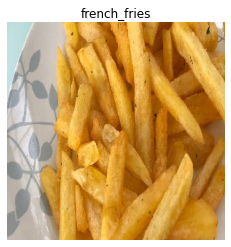

prediction: [[1.1447626e-03 6.3626794e-04 7.6165795e-04 1.2714243e-01 9.6134824e-04
  4.3906464e-04 2.7528593e-02 8.8502318e-02 9.9665881e-04 1.2639734e-03
  3.0820507e-03 1.8039769e-03 7.3990601e-01 7.8336790e-04 2.1424911e-03
  2.9050102e-03]]
index: 12
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: ramen


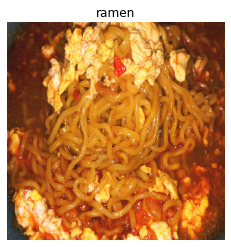

prediction: [[5.1956082e-04 2.6627653e-04 1.9213780e-04 6.8298027e-02 3.1929973e-03
  1.7631952e-02 2.0715124e-03 2.2102243e-03 4.9170811e-04 5.3422229e-04
  9.0275550e-01 3.3449591e-04 5.1210367e-04 3.8395051e-04 1.6624651e-04
  4.3917116e-04]]
index: 10
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: omelette


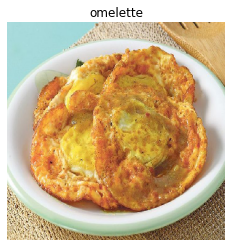

prediction: [[6.22406544e-04 4.22189449e-04 3.47339374e-04 5.48910797e-01
  2.69077033e-01 3.22269881e-03 3.38778575e-03 2.87162475e-02
  1.42308336e-03 7.01806159e-04 2.75991391e-02 7.04149948e-04
  7.05534359e-03 1.04570635e-01 1.22122583e-03 2.01808242e-03]]
index: 3
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: chicken_curry


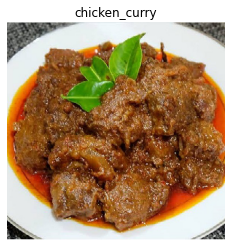

prediction: [[0.0012975  0.00071357 0.00104735 0.09430512 0.17666776 0.00092938
  0.00353362 0.00843687 0.01011557 0.00199124 0.00710646 0.00122213
  0.00133256 0.67972237 0.00450622 0.00707232]]
index: 13
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: rendang


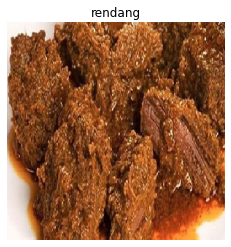

prediction: [[0.00350778 0.00282462 0.00679209 0.05062821 0.10280175 0.00503265
  0.01104522 0.01796094 0.1030106  0.00555858 0.0300685  0.00476761
  0.01080779 0.5750386  0.01917993 0.05097508]]
index: 13
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: rendang


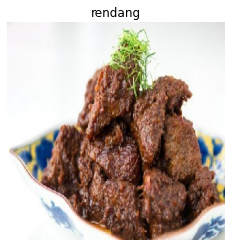

prediction: [[1.21021294e-03 9.04456014e-04 1.30502577e-03 8.12116172e-03
  4.75009234e-04 2.94986472e-04 1.69108773e-03 1.26765817e-01
  2.65094033e-03 1.11942680e-03 4.22617933e-03 8.02103430e-04
  5.00009721e-03 1.63547266e-02 8.18816006e-01 1.02627445e-02]]
index: 14
Food list: ['apple', 'banana', 'cabbage', 'chicken_curry', 'chicken_wings', 'eggs_benedict', 'french_fries', 'fried_rice', 'lettuce', 'mango', 'omelette', 'orange', 'ramen', 'rendang', 'rice', 'spinach']
gambar prediksi: rice


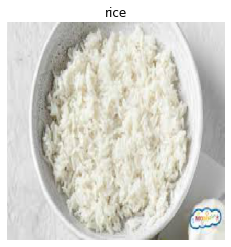

In [ ]:
# Make a list of downloaded images and test the trained model
images = []
images.append('chicken_curry.jpg')
images.append('chicken_wings.jpg')
images.append('omelette.jpg')
images.append('nasi_goreng.jpg')
images.append('kentang_goreng.jpg')
images.append('mie.jpg')
images.append('telor_ceplok.jpg')
#images.append('gambar_rendang.jpg')
#images.append('selada.jpg')
images.append('rendang.jpg')
images.append('rendang_aja.jpg')
images.append('rendang4.jpg')
images.append('nasi.jpg')
print(images)
predict_class(model_best, images, True)

* **Yes!!! The model got them all right!!**